In [13]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time

% matplotlib inline

""" Some constants"""
deff = 68.5 #pm/V

epsilon0 = 8.85e-12 # F/m
#n_THz = 3.2# https://refractiveindex.info/?shelf=main&book=ZnTe&page=Marple
n_group = 3.0
bandwidth = 10e-6 # mm
c = 0.3
pi = np.pi
center_wavelength = 800e-6

In [14]:
""" RK 4 """
def rk4(f, x0, y0, x1, n):
    vx = [0] * (n + 1)
    vy = [0] * (n + 1)
    h = (x1 - x0) / float(n)
    vx[0] = x = x0
    vy[0] = y = y0
    for i in range(1, n + 1):
        k1 = h * f(x, y)
        k2 = h * f(x + 0.5 * h, y + 0.5 * k1)
        k3 = h * f(x + 0.5 * h, y + 0.5 * k2)
        k4 = h * f(x + h, y + k3)
        vx[i] = x = x0 + i * h
        vy[i] = y = y + (k1 + k2 + k2 + k3 + k3 + k4) / 6
    return vy
# vx - an array for x variable, vy - an array for f(x), x0 - inital x, y0 - f(x0), x1 - end point for x, n - number of points

In [17]:
"""Multiple THz frequency (0.1 ~ 300) -- for loop"""
# Define the ODE
omega0 = c*2*pi/center_wavelength
w = c*2*pi/(center_wavelength-bandwidth/2)-c*2*pi/(center_wavelength+bandwidth/2)
omega = np.linspace(0,2*omega0, 1000)

OTHz = 0.1*2*pi
size = 1000
OTHz = np.linspace(0.,300.,size)
step = np.mean(np.diff(OTHz))
num = 1000

P = np.zeros([size,1])
K = np.zeros([size,1])

def mainprocess(THz):
    def optE(omega, omega0, w):
        return np.exp(-4*np.log(2)*((omega-omega0)/w)**2)
    E = optE(omega, omega0, w)
    i = np.int_(THz/step)
    pNL = np.dot(E[:-i],E[i:])
    n_THz = np.exp(np.log(1.25)/75*(THz))+5.65
    #n_THz = 3.2
    #alpha = np.exp(6e-3*THz)+1
    alpha = 1
    delta_k = (THz/c)*(n_THz-n_group)
    #delta_k = 0
    def ODE(z, ETHz):
        return (-1j*THz*c/2/n_THz)*pNL*np.exp(1j*delta_k*z) - 0.5*alpha*ETHz
    e = rk4(ODE, 0,0,8.5,num-1)

    # Er - 2D array for real part, Ei - 2D array for imaginary part, E - 2D array for amplitude, P - 1D array for pNL, K - 1D array for delta_k
    return e

In [18]:
t0 = time.time()
if __name__ == '__main__':
    p = Pool(4)
    e = p.map(mainprocess, OTHz)
print(time.time()-t0)

ValueError: shapes (0,) and (1000,) not aligned: 0 (dim 0) != 1000 (dim 0)

In [11]:
E = np.zeros([size, num])
Er = np.zeros([size, num])
Ei = np.zeros([size, num])

Er[:] = np.real(e)
Ei[:] = np.imag(e)
E[:] = np.absolute(e)
z = np.linspace(0,8.5,num)

(0, 100)

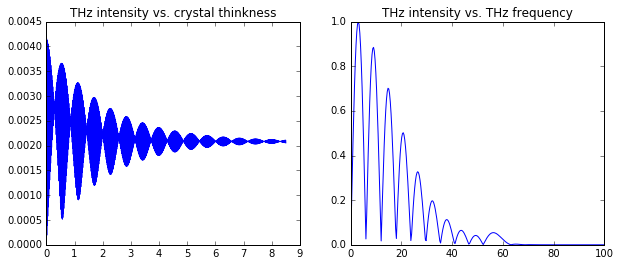

In [12]:
""" Plotting - Spectrum """
fig, ax = plt.subplots(1,2,figsize=(10,4))
line1, = ax[0].plot(z, E[100,:],label='freq: 5 ')
#line2, = ax[0].plot(z, E[1000,:],label='freq: 50')
#line3, = ax[0].plot(z, E[3000,:],label='freq: 150.0')
#line4, = ax[0].plot(z, E[5999,:],label='freq: 300.0')
ax[0].set_title('THz intensity vs. crystal thinkness')
ax[1].plot(OTHz, E[:,10]/max(E[:,10]))#, OTHz, E[:,100]/max(E[:,100]), OTHz, E[:,500]/max(E[:,500]), OTHz, E[:,1000]/max(E[:,1000]))
ax[1].set_title('THz intensity vs. THz frequency')
ax[1].set_xlim(0,100)

(0, 100)

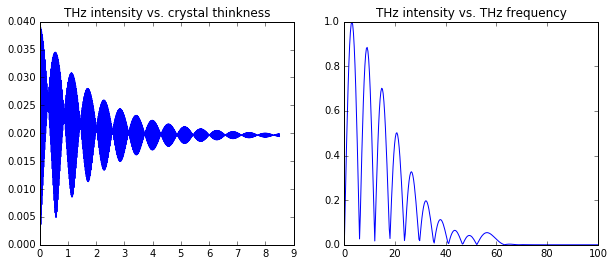

In [7]:
""" Plotting - Spectrum """
fig, ax = plt.subplots(1,2,figsize=(10,4))
line1, = ax[0].plot(z, E[100,:],label='freq: 5 ')
#line2, = ax[0].plot(z, E[1000,:],label='freq: 50')
#line3, = ax[0].plot(z, E[3000,:],label='freq: 150.0')
#line4, = ax[0].plot(z, E[5999,:],label='freq: 300.0')
ax[0].set_title('THz intensity vs. crystal thinkness')
ax[1].plot(OTHz, E[:,10]/max(E[:,10]))#, OTHz, E[:,100]/max(E[:,100]), OTHz, E[:,500]/max(E[:,500]), OTHz, E[:,1000]/max(E[:,1000]))
ax[1].set_title('THz intensity vs. THz frequency')
ax[1].set_xlim(0,100)

6.00214322688e-15
5.04631059162e-15
5.99520433298e-15
5.88071258356e-15
5.93275428784e-15
5.88765147747e-15
5.9431626287e-15
5.93622373479e-15


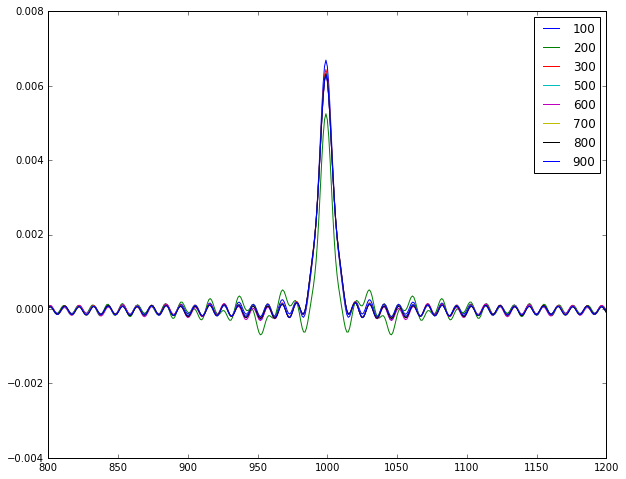

In [8]:
""" Plotting - waveform """
fig,ax=plt.subplots(figsize=(10,8))
for i in [100,200,300,500,600,700,800,900]:
    length=Er[:,0].size
    Ec = np.zeros(length*2-1,dtype=complex)
    loc=i
    Ec[:length-1]=np.flipud(Er[1:,loc])+1j*np.flipud(Ei[1:,loc])
    Ec[length-1:]=(Er[:,loc]+1j*Ei[:,loc])

    Ec=np.absolute(Ec)

    FFT=np.fft.ifftshift(Ec)
    wf=np.real(np.fft.ifft(FFT))
    
    ax.plot(np.arange(0,wf.size),np.fft.fftshift(wf),label=loc)
    ax.set_xlim(length-length/5,length+length/5)
    print(np.sum(wf))
ax.legend()